# Описание проекта: промышленность

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Ваша задача — построить модель, которая будет её предсказывать. 
Заказчик хочет использовать разработанную модель для имитации технологического процесса. Ниже расскажем о деталях этого процесса. Их важно знать, прежде чем генерировать новые признаки.

# Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 
Из сплава выводится сера (этот процесс — десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (от англ. tribe — «масса»).<br>
Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (от англ. slab — «плита»).

# Работа с библиотеками

<i>Вывод ошибок<i>

In [7]:
import warnings
warnings.filterwarnings('ignore')

### Установка/обновление библиотек

In [9]:
# !pip install matplotlib==3.8.4
# !pip install seaborn==0.13.2

# !pip install phik
# !pip install scikit-learn==1.4.0
# !pip install shap==0.45.1
# !pip install catboost
# ;

### Импорт библиотек

<i>Работа с данными, визуализация<i>

In [12]:
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

<i>Матрица корреляции<i>

In [14]:
from phik.report import plot_correlation_matrix
from phik import phik_matrix

<i>Shap<i>

In [16]:
import shap

<i>Библиотека sklearn<i>

In [18]:
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import (OneHotEncoder,
                                   OrdinalEncoder,
                                   StandardScaler,
                                   MinMaxScaler,
                                   RobustScaler)
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import mean_absolute_error

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

# загружаем нужные модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

# загружаем функцию для проверки значимости показателей в модели
from sklearn.inspection import permutation_importance

<i>Библиотека CatBoost<i>

In [20]:
from catboost import CatBoostRegressor

<i>Библиотека tqdm<i>

In [22]:
from tqdm import notebook
from tqdm.notebook import tqdm
tqdm.pandas()

<i>Настройка pandas<i>

In [24]:
pd.set_option('display.max_colwidth', None)

In [25]:
matrix_on = True

## Загрузка данных

In [27]:
data_arc_new = pd.read_csv('data_arc_new.csv', parse_dates=['Начало нагрева дугой', 'Конец нагрева дугой'])
data_bulk_new = pd.read_csv('data_bulk_new.csv')
data_bulk_time_new = pd.read_csv('data_bulk_time_new.csv')
data_gas_new = pd.read_csv('data_gas_new.csv')
data_temp_new = pd.read_csv('data_temp_new.csv', parse_dates=['Время замера'])
data_wire_new = pd.read_csv('data_wire_new.csv')
data_wire_time_new = pd.read_csv('data_wire_time_new.csv')

## Исследовательский анализ и предобработка данных

Функция для проверки процента разницы исходных данных с конечными

In [30]:
def percent_div(first_variable, second_variable):
    percent_out = 100 - (first_variable - second_variable) / first_variable * 100
    print('Количество уникальных записей: ', round(percent_out, 2), ' %')
    return percent_out

Функция для вывода основной информации о датасете

In [32]:
def data_check(data_in):
    display(data_in.head())
    display(data_in.info())
    display(data_in.describe())
    percent_div(len(data_in), len(data_in.drop_duplicates()))

### Общая информация о датасетах

#### data_arc_new

In [35]:
data_check(data_arc_new)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


None

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
count,14876.000000,14876,14876,14876.000000,14876.000000
mean,1615.220422,2019-07-05 12:25:51.921081088,2019-07-05 12:28:43.592027392,0.662752,0.438986
min,1.000000,2019-05-03 11:02:14,2019-05-03 11:06:02,0.223120,-715.479924
25%,806.000000,2019-06-03 23:18:23.249999872,2019-06-03 23:21:35,0.467115,0.337175
50%,1617.000000,2019-07-03 01:31:26.500000,2019-07-03 01:35:13,0.599587,0.441639
75%,2429.000000,2019-08-07 22:52:20.750000128,2019-08-07 22:56:47,0.830070,0.608201
max,3241.000000,2019-09-06 17:24:54,2019-09-06 17:26:15,1.463773,1.270284
std,934.571502,NaN,NaN,0.258885,5.873485


Количество уникальных записей:  100.0  %


Пропущенных значений нет, записи уникальны. Присутствуют значения менее 0, их следует убрать.

#### data_bulk_new

In [38]:
data_check(data_bulk_new)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.3 KB


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Количество уникальных записей:  100.0  %


Существуют пропущенные значения, записи уникальны<br>
Следует посмотреть датасет "data_bulk_time_new". Дольнейшие выводы будем делать по таблице "data_bulk_time_new".

'Bulk 8' Имеет только 1 значение. Его стоит убрать.

#### data_bulk_time_new

In [42]:
data_check(data_bulk_time_new)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.3+ KB


None

,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


Количество уникальных записей:  100.0  %


Таблица по общей информации аналогична "data_bulk_new". Поэтому общий вывод по этим датасетам будем делать после их объединения. Также пропущенные значения таблиц "data_bulk_new" заменим на 0.

#### data_gas_new

In [45]:
data_check(data_gas_new)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Количество уникальных записей:  100.0  %


In [46]:
len(data_gas_new['key'].unique())

3239

Пропущенных значений нет, записи уникальны

#### data_temp_new

In [49]:
data_check(data_temp_new)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


None

,key,Время замера,Температура
count,18092.000000,18092,14665.000000
mean,1616.460977,2019-07-05 13:36:58.791620608,1590.722741
min,1.000000,2019-05-03 11:02:04,1191.000000
25%,807.750000,2019-06-04 00:35:01.249999872,1580.000000
50%,1618.000000,2019-07-03 02:11:48,1590.000000
75%,2429.000000,2019-08-07 23:10:05.249999872,1599.000000
max,3241.000000,2019-09-06 17:30:05,1705.000000
std,934.641385,NaN,20.394381


Количество уникальных записей:  100.0  %


Присутствуют пропущенные значения температур. Суди по первым записям, мы имеем замер температур на определенном участке времени, соответсвенно агрегируем данные во первой и последней температуре, а также выделим столбец со средней температурой. Записи для которых нет данных следует убрать.

#### data_wire_new

In [52]:
data_check(data_wire_new)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Количество уникальных записей:  100.0  %


Существуют пропущенные значения, записи уникальны
Следует посмотреть датасет "data_wire_time_new" для вывода по таблице "data_wire_new"

'Wire 5' Имеет только 1 значение. Его стоит убрать.

#### data_wire_time_new

In [56]:
data_check(data_wire_time_new)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


Количество уникальных записей:  100.0  %


Таблица по общей информации аналогична "data_wire_new". Поэтому общий вывод по этим датасетам будем делать после их объединения. Также пропущенные значения таблиц "data_bulk_new" заменим на 0.

### Предобработка данных

#### data_arc_new

Начало и конец нагрева дугой заменим на длительность нагрева. Далее агрегируем данные.

In [61]:
drop_key_power = data_arc_new[
     (data_arc_new['Реактивная мощность'] <= 0) | (data_arc_new['Активная мощность'] <= 0)
 ]['key'].unique()
drop_key_power

array([2116], dtype=int64)

In [62]:
data_arc_new['Длительность нагрева дугой'] = data_arc_new['Конец нагрева дугой'] - data_arc_new['Начало нагрева дугой']
data_arc_new['Длительность нагрева дугой'] = data_arc_new['Длительность нагрева дугой'].\
                                                  astype('timedelta64[s]').astype('int64')

In [63]:
work_data_arc_new = data_arc_new[~data_arc_new['key'].isin(drop_key_power)]

work_data_arc_new = work_data_arc_new[
        (work_data_arc_new['Начало нагрева дугой'] <= work_data_arc_new['Конец нагрева дугой']) |\
        (work_data_arc_new['Конец нагрева дугой'] >= work_data_arc_new['Начало нагрева дугой'])
]

In [64]:
work_data_arc_new = work_data_arc_new.groupby('key').agg(
    total_time_heating = ('Длительность нагрева дугой', 'sum'),
    mean_time_heating = ('Длительность нагрева дугой', 'mean'),
    cnt_heating = ('key', 'count'),
    active_power = ('Активная мощность', 'sum'),
    reactive_power = ('Реактивная мощность', sum)
).reset_index()

In [65]:
work_data_arc_new['total_power'] = ((work_data_arc_new['active_power'])**2 +\
                                        (work_data_arc_new['reactive_power'])**2)**0.5
work_data_arc_new['total_work'] = work_data_arc_new['total_power'] * work_data_arc_new['total_time_heating']

In [66]:
work_data_arc_new

,key,total_time_heating,mean_time_heating,cnt_heating,active_power,reactive_power,total_power,total_work
0,1,1098,219.60,5,3.036730,2.142821,3.716640,4080.870431
1,2,811,202.75,4,2.139408,1.453357,2.586371,2097.546600
2,3,655,131.00,5,4.063641,2.937457,5.014163,3284.276844
3,4,741,185.25,4,2.706489,2.056992,3.399456,2518.996645
4,5,869,217.25,4,2.252950,1.687991,2.815155,2446.369640
...,...,...,...,...,...,...,...,...
3208,3237,909,181.80,5,2.541872,2.025417,3.250143,2954.379675
3209,3238,546,182.00,3,1.374821,1.038103,1.722728,940.609307
3210,3239,1216,152.00,8,4.848005,3.541541,6.003804,7300.625934
3211,3240,839,167.80,5,3.317679,2.373552,4.079307,3422.538310


#### data_bulk_new

Для данного датасета необходимо заменить пропущенные значения на 0, поскольку это пропущенное значение значит отсутствие присадок

In [69]:
work_data_bulk_new = data_bulk_new.fillna(0)
work_data_bulk_new.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


In [70]:
name_bulk = [str.lower(i).replace(' ', '_') for i in list(work_data_bulk_new.columns)]
work_data_bulk_new.columns = name_bulk

In [71]:
work_data_bulk_new['sum_bulk'] = work_data_bulk_new[name_bulk[1:]].sum(axis=1)
work_data_bulk_new.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,sum_bulk
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,553.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,582.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,544.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,595.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,584.0


#### data_temp_new

Для данного датасета убираем записи с температурой менее рекомендованной - 1400 градусов, также отберем только начальную и конечную температуры<br>
P.S. тесты показали, что стоит отфильтровать данные по температуре плавления (1550). Судя по всему, это нарушение технологического процесса для которого нужны дополнительные данные.

Минимальная температура

In [75]:
min_temp = 1500

Начальная и конечная температуры

Выделим ключи, которые не подходят по температуре

In [78]:
drop_key_temp = data_temp_new[data_temp_new['Температура'] < min_temp]['key'].unique()
drop_key_temp

array([ 867, 1214, 1619, 2052, 2561], dtype=int64)

In [79]:
work_data_temp_new = data_temp_new.sort_values(
    by=['key', 'Время замера']
)
work_data_temp_new = work_data_temp_new[~work_data_temp_new['key'].isin(drop_key_temp)]
work_data_temp_new[work_data_temp_new['key']==1]

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0


In [80]:
display(data_temp_new[data_temp_new['key']==867])

,key,Время замера,Температура
4883,867,2019-06-06 08:03:39,1191.0
4884,867,2019-06-06 08:18:52,1575.0
4885,867,2019-06-06 08:22:38,1576.0
4886,867,2019-06-06 08:25:11,1571.0
4887,867,2019-06-06 08:29:49,1600.0
4888,867,2019-06-06 08:36:49,1522.0
4889,867,2019-06-06 08:43:02,1521.0
4890,867,2019-06-06 08:48:23,1599.0


In [81]:
work_data_temp_new = work_data_temp_new.pivot_table(index='key', values='Температура', aggfunc=['first', 'last', 'count'])
work_data_temp_new.columns=['start_temp', 'end_temp', 'cnt_temp']
work_data_temp_new = work_data_temp_new.reset_index()

In [82]:
work_data_temp_new.sort_values(by='cnt_temp').head()

,key,start_temp,end_temp,cnt_temp
3210,3241,1586.0,1586.0,1
2930,2959,1606.0,1606.0,1
2661,2690,1569.0,1569.0,1
2929,2958,1617.0,1617.0,1
2928,2957,1539.0,1539.0,1


Для части ковшей присутствует только одно измерение температуры, что значит отсутствие данных для их нагрева. Такие ковши следует исключить

In [84]:
drop_key_cnt_temp = work_data_temp_new[work_data_temp_new['cnt_temp'] <= 1]['key'].unique()
len(drop_key_cnt_temp)

740

In [85]:
work_data_temp_new = work_data_temp_new[work_data_temp_new['cnt_temp'] > 1]
work_data_temp_new = work_data_temp_new.drop(columns='cnt_temp')

In [86]:
work_data_temp_new = work_data_temp_new[
    (work_data_temp_new['start_temp'] >= min_temp) |\
    (work_data_temp_new['end_temp'] >= min_temp)
]

In [87]:
display(work_data_temp_new.describe())

,key,start_temp,end_temp
count,2471.000000,2471.000000,2471.000000
mean,1250.484015,1589.012950,1595.339943
std,720.109488,25.004369,16.035215
min,1.000000,1519.000000,1541.000000
25%,628.500000,1572.000000,1587.000000
50%,1252.000000,1588.000000,1593.000000
75%,1872.500000,1605.000000,1599.000000
max,2499.000000,1679.000000,1700.000000


#### data_wire_new

Для данного датасета заменим пропущенные значения на 0, что значит отсутствие добавок

In [90]:
work_data_wire_new = data_wire_new.fillna(0)
work_data_wire_new.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [91]:
name_wire = [str.lower(i).replace(' ', '_') for i in list(work_data_wire_new.columns)]
work_data_wire_new.columns = name_wire

In [92]:
work_data_wire_new['sum_wire'] = work_data_wire_new[name_wire[1:]].sum(axis=1)
work_data_wire_new.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,sum_wire
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.063515
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.352796


#### data_gas_new

In [94]:
data_gas_new.columns=['key', 'gas']
data_gas_new.columns

Index(['key', 'gas'], dtype='object')

### Вывод

1) Для таблиц 'data_bilk_new' и 'data_wire_new' пропущенные значения заменены на 0, что значит отсутствие добавок;<br>
2) Данные по времени агрегированы и преобразованы до начальной и конечной точек;<br>
3) Отобраны ключи, которые не соответствуют технологическим параметрам.

## Объединение данных

Для общего датасета соберем все подготовленные таблицы за исключением таблиц только со временем ('data_bulk_time_new', 'data_wire_time_new')

### Объединение данных

In [100]:
list_df = [
    work_data_bulk_new, data_gas_new,
    work_data_temp_new, work_data_wire_new
]

data_work = work_data_arc_new
for i in list_df:
    data_work = data_work.merge(i, how='inner', on='key')

In [101]:
data_work.head()

,key,total_time_heating,mean_time_heating,cnt_heating,active_power,reactive_power,total_power,total_work,bulk_1,bulk_2,...,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,sum_wire
0,1,1098,219.60,5,3.036730,2.142821,3.716640,4080.870431,0.0,0.0,...,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998
1,2,811,202.75,4,2.139408,1.453357,2.586371,2097.546600,0.0,0.0,...,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315
2,3,655,131.00,5,4.063641,2.937457,5.014163,3284.276844,0.0,0.0,...,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157
3,4,741,185.25,4,2.706489,2.056992,3.399456,2518.996645,0.0,0.0,...,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.063515
4,5,869,217.25,4,2.252950,1.687991,2.815155,2446.369640,0.0,0.0,...,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.352796


Проверка на наличие ключей для исключения.

In [103]:
data_work[data_work['key'].isin(drop_key_temp)==True].count().mean(),\
data_work[data_work['key'].isin(drop_key_power)==True].count().mean(),\
data_work[data_work['key'].isin(drop_key_cnt_temp)==True].count().mean()

(0.0, 0.0, 0.0)

### Вывод

Данные объединены и проверены на наличие ключей для исключения

## Исследовательский анализ и предобработка данных объединённого датафрейма

Проверим данные на выбросы через гистограммы

In [108]:
columns_check = list(data_work.drop(columns='key').columns);

### Визуализация данных (гистограммы)

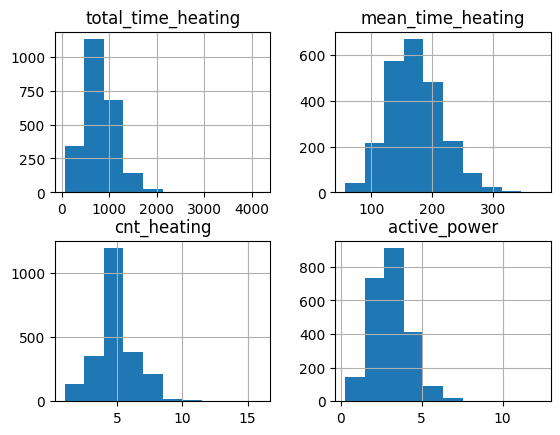

In [110]:
data_work.loc[:,columns_check[:4]].hist();

Общее время и количество нагревов является показателем отклонения от тех. процесса. Наблюдаются выбросы в этих показателях.

In [112]:
data_work[data_work['total_time_heating'] > 2000]

,key,total_time_heating,mean_time_heating,cnt_heating,active_power,reactive_power,total_power,total_work,bulk_1,bulk_2,...,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,sum_wire
41,44,2063,171.916667,12,7.298996,5.221229,8.974217,18513.810144,0.0,0.0,...,69.189123,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,69.189123
42,45,2136,213.600000,10,6.272281,4.564355,7.757245,16569.474703,0.0,0.0,...,114.354237,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,114.354237
43,46,2919,224.538462,13,9.180259,7.051945,11.576143,33790.761018,0.0,0.0,...,100.245593,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,100.245593
289,322,2658,204.461538,13,8.914806,6.564143,11.070761,29426.081564,185.0,0.0,...,0.000000,188.228550,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,188.228550
590,638,2067,187.909091,11,7.270996,4.981813,8.813957,18218.449776,0.0,0.0,...,169.322388,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,169.322388
747,813,2247,249.666667,9,6.099306,4.467993,7.560721,16988.939060,0.0,0.0,...,29.250000,85.141678,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,114.391678
1413,1513,2526,168.400000,15,11.632350,8.572990,14.450181,36501.156606,0.0,0.0,...,130.197596,60.229519,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,190.427115
1575,1689,4189,279.266667,15,12.375636,8.949049,15.272257,63975.486018,0.0,0.0,...,187.153206,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,187.153206
1755,1880,2755,250.454545,11,6.149070,4.263111,7.482324,20613.803508,0.0,0.0,...,70.199997,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,70.199997
1869,2001,2065,295.000000,7,4.939771,3.481827,6.043547,12479.923948,0.0,0.0,...,39.180960,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,39.180960


Наблюдаются явные выбросы более 2100, что больше на 25% этой планки. Поэтому отфильтруем эти значения.

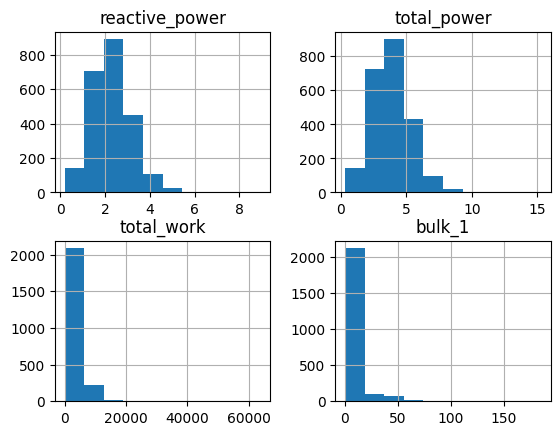

In [114]:
data_work.loc[:,columns_check[4:8]].hist();

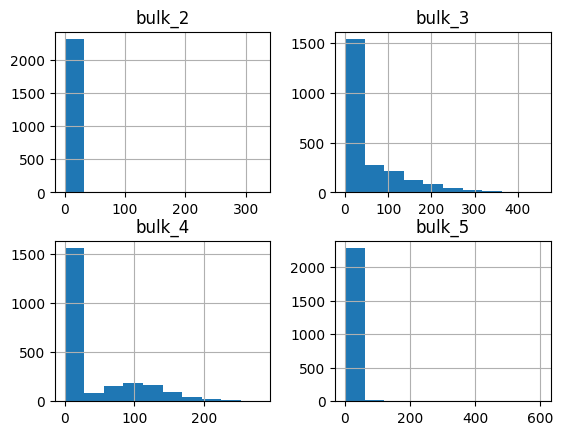

In [115]:
data_work.loc[:,columns_check[8:12]].hist();

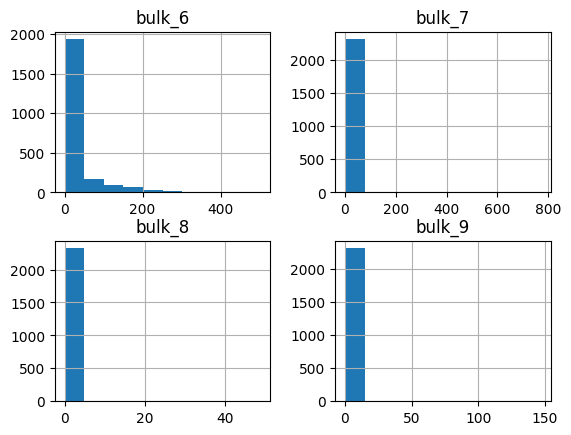

In [116]:
data_work.loc[:,columns_check[12:16]].hist();

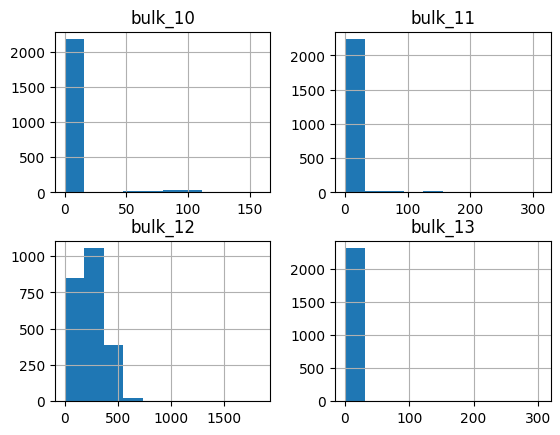

In [117]:
data_work.loc[:,columns_check[16:20]].hist();

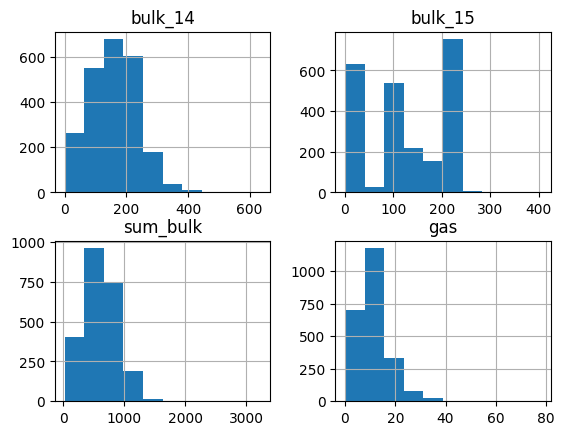

In [118]:
data_work.loc[:,columns_check[20:24]].hist();

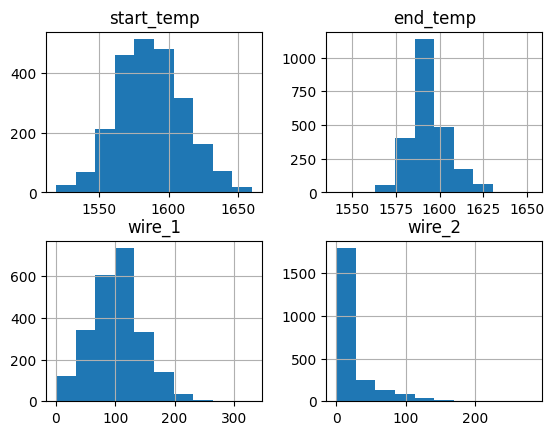

In [119]:
data_work.loc[:,columns_check[24:28]].hist();

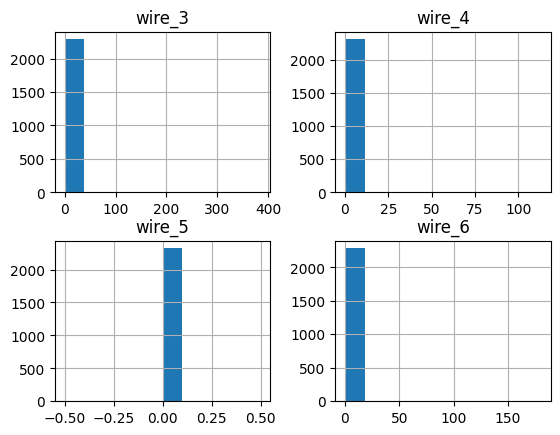

In [120]:
data_work.loc[:,columns_check[28:32]].hist();

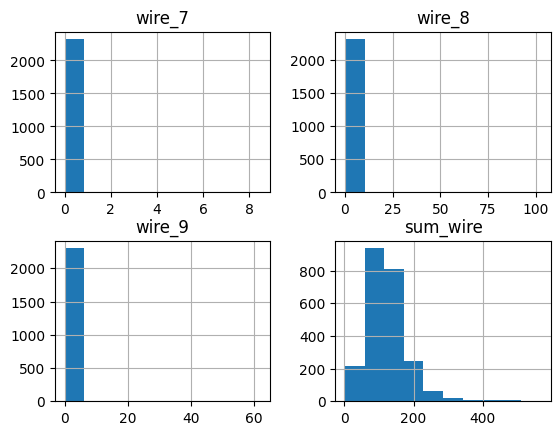

In [121]:
data_work.loc[:,columns_check[32:]].hist();

### Матрица корреляции


In [123]:
interval_cols = ['total_time_heating']
drop_columns = ['key', 'mean_time_heating']

''

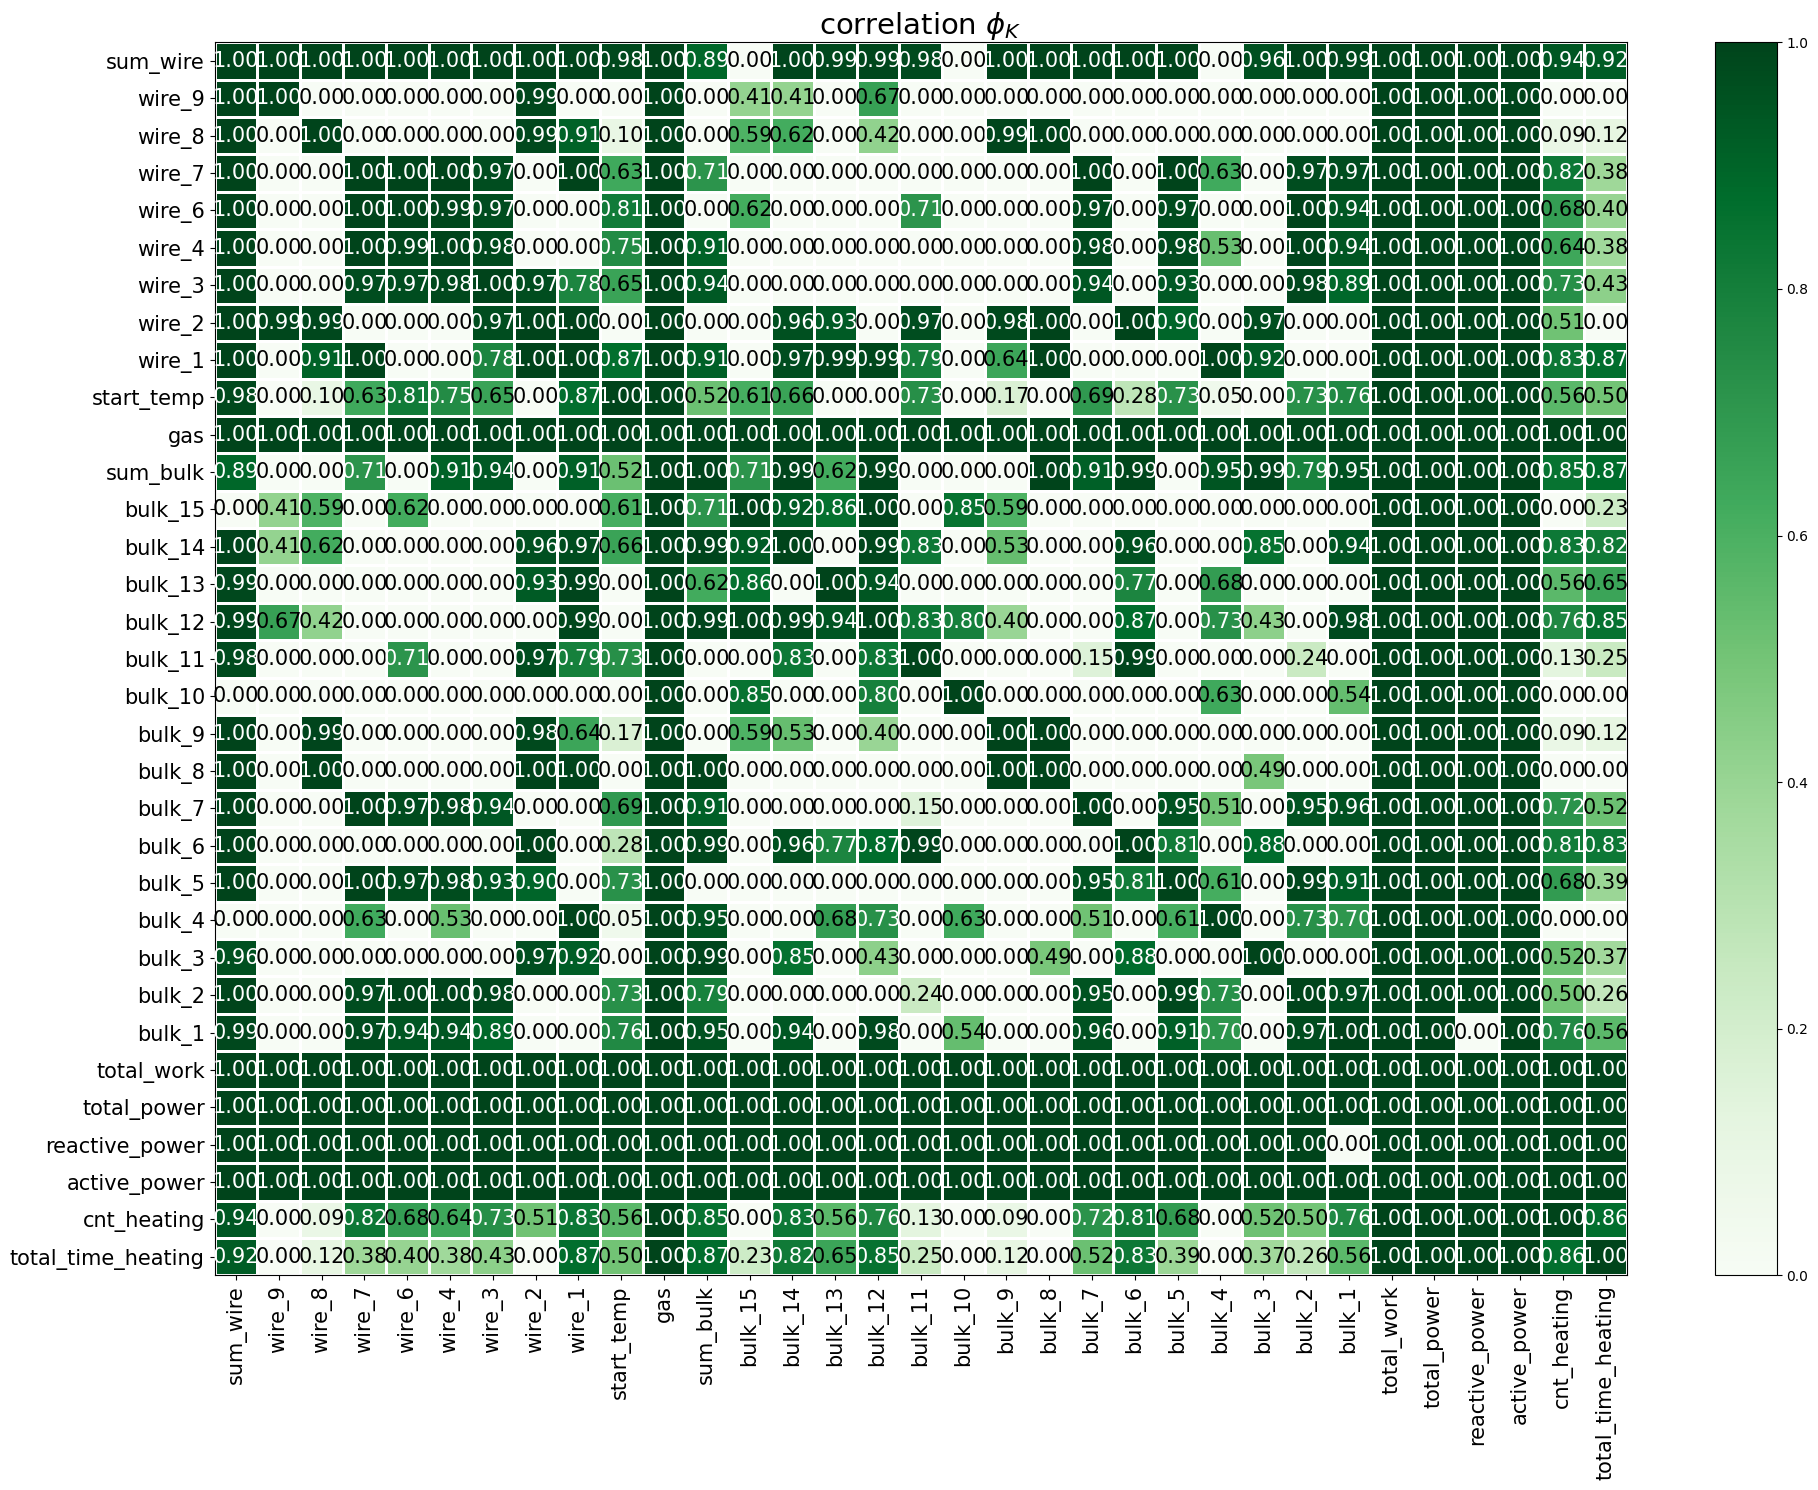

In [124]:
if matrix_on:
    phik_overview_1 = phik_matrix(data_work.drop(columns=[*drop_columns, 'end_temp'], axis=1),
                                interval_cols=interval_cols)

    plot_correlation_matrix(
        phik_overview_1.values,
        x_labels=phik_overview_1.columns,
        y_labels=phik_overview_1.index,
        vmin=0, vmax=1, color_map='Greens',
        title=r'correlation $\phi_K$',
        fontsize_factor=1.5,
        figsize=(20, 15)
    )
;

По данной матрице явно выделяются:<br>
1) gas;<br>
2) total_work;<br>
3) power;<br>
4) некоторые 'wire', 'bulk'.

### Корреляция bulk

In [127]:
bulc_columns = name_bulk[1:]

interval columns not set, guessing: ['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']


''

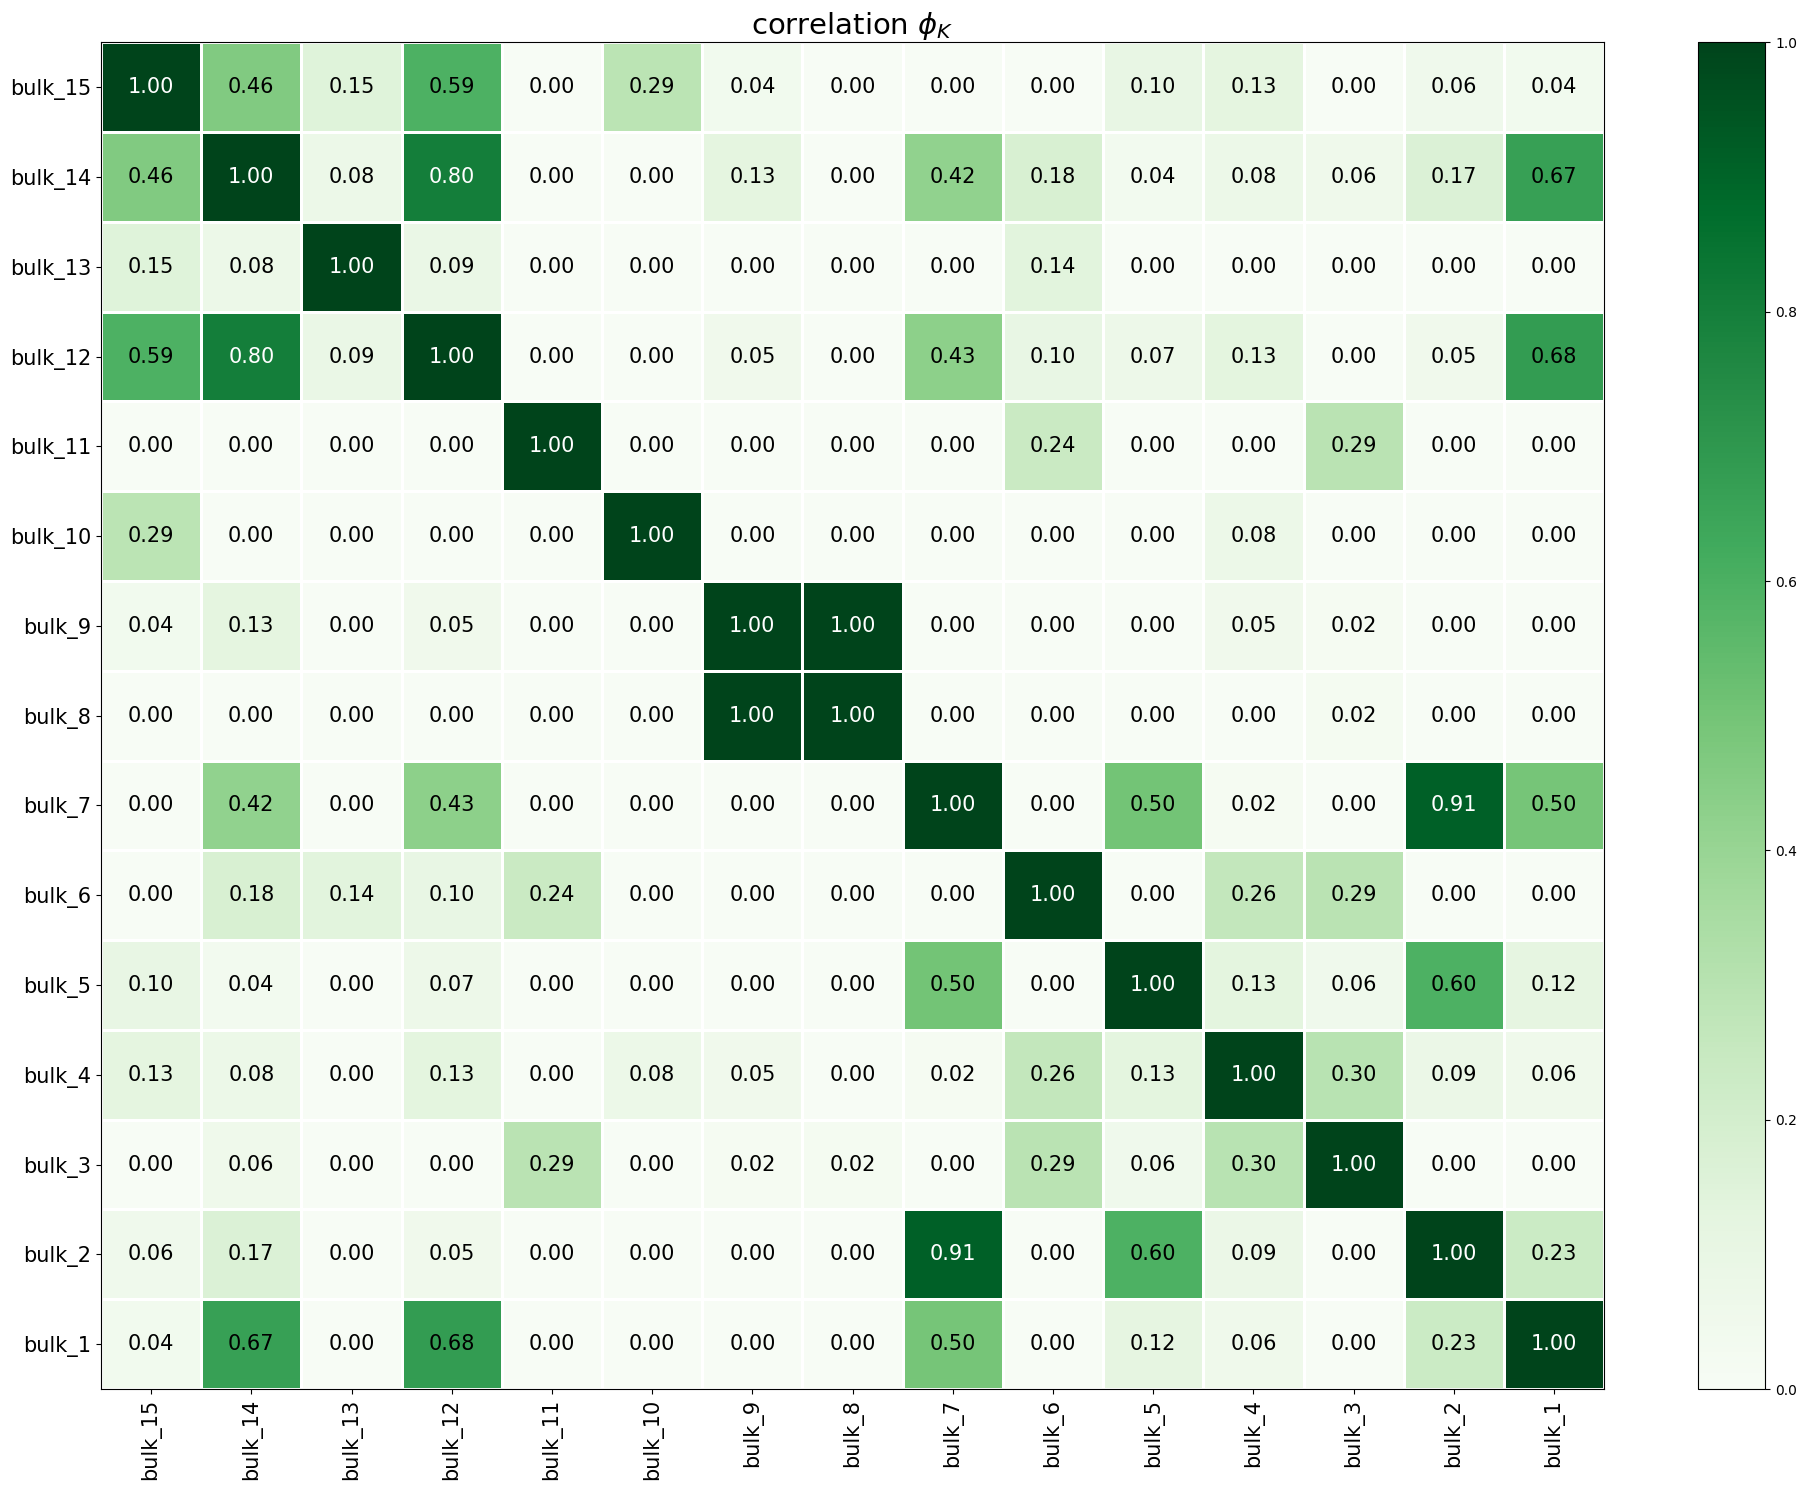

In [128]:
if matrix_on:
    phik_overview = phik_matrix(data_work[bulc_columns]) 
    plot_correlation_matrix(
        phik_overview.values,
        x_labels=phik_overview.columns,
        y_labels=phik_overview.index,
        vmin=0, vmax=1, color_map='Greens',
        title=r'correlation $\phi_K$',
        fontsize_factor=1.5,
        figsize=(20, 15)
    )
;

По данной матрице имеется высокая корреляция между 'ublk_8', 'bulk_9'. Посклькольку 'bulk_8' имеет малые коэффициенты корреляции по сравнению с 'bulk_9' и кореелирует между собой, то стоит его убрать.

### Корреляция wire

In [131]:
wire_columns = name_wire[1:]

interval columns not set, guessing: ['wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9']


''

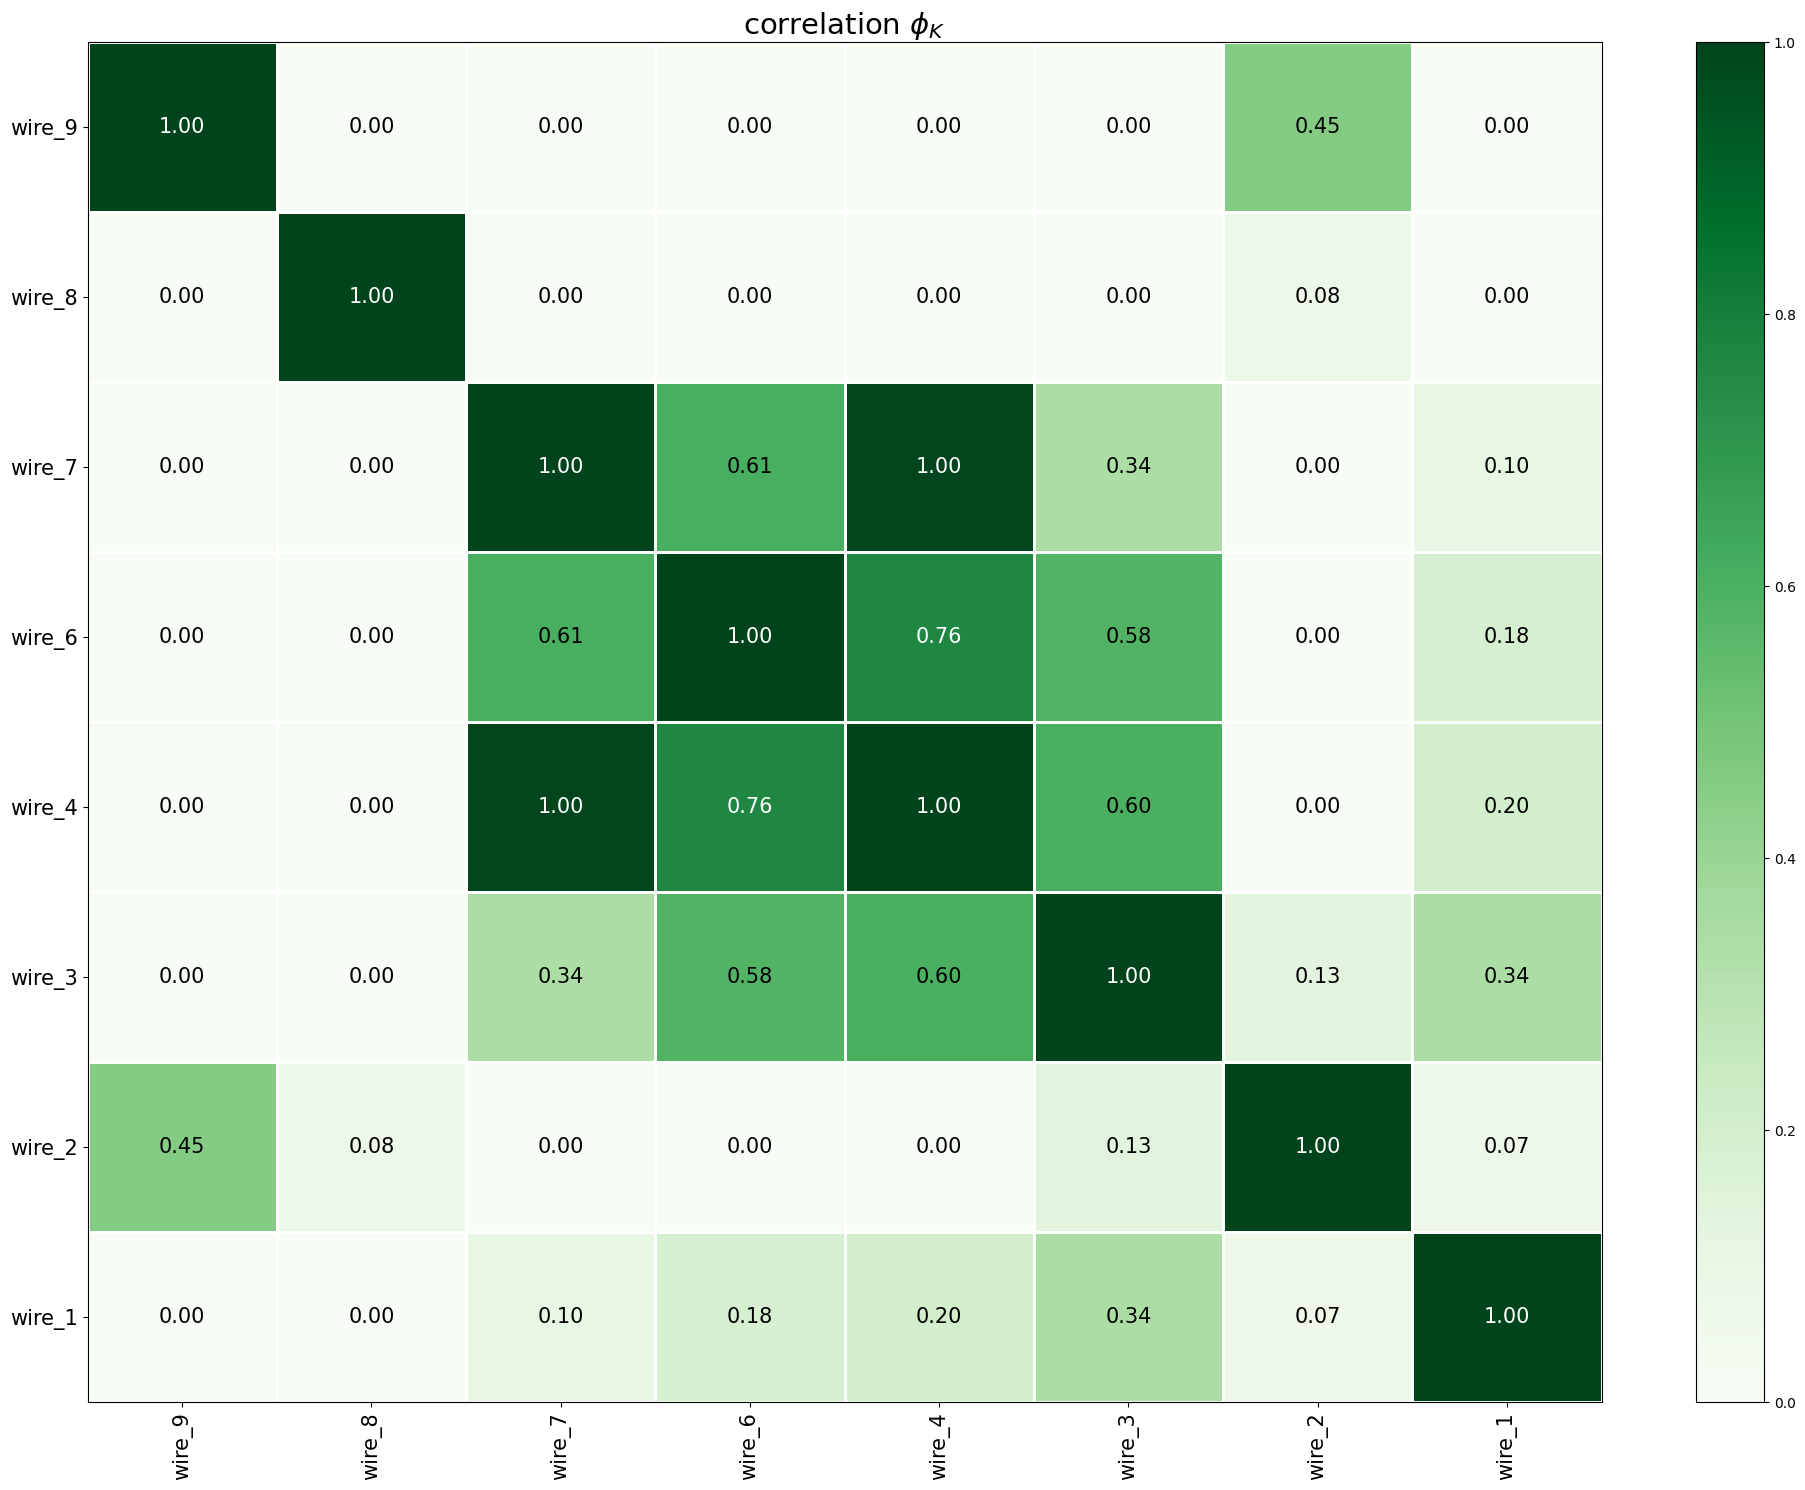

In [132]:
if matrix_on:
    phik_overview = phik_matrix(data_work[wire_columns]) 
    plot_correlation_matrix(
        phik_overview.values,
        x_labels=phik_overview.columns,
        y_labels=phik_overview.index,
        vmin=0, vmax=1, color_map='Greens',
        title=r'correlation $\phi_K$',
        fontsize_factor=1.5,
        figsize=(20, 15)
    )
;

По мощности выделяются "wire_7" и "wire_4", которые коррелируют друг с другом. Также нет "wire_5". Следует исключить "wire_7" и "wire_5".

In [134]:
drop_columns_2 = [
    *drop_columns, 'reactive_power'
    ,'bulk_8', 'wire_5', 'wire_7'
]

In [135]:
data_work['key'].drop_duplicates().count() / data_arc_new['key'].drop_duplicates().count() * 100

72.30864965774735

### Вывод

1) С помощью гистограмм проверили наличие аномалий после обработки;<br>
2) Определили какие данные можно убрать из модели по матрице корреляции. Ими оказались:<br>
'reactive_power' ,'bulk_8', 'wire_5', 'wire_7'

## Подготовка данных

### Подготовка данных

Критерий модели обучения

In [141]:
drop_columns = ['key', 'mean_time_heating']

In [142]:
MAE_target = 6.8

Необходимые параметры

In [144]:
target_column = 'end_temp'
drop_columns_for_model = [
    *drop_columns_2,
    target_column, 'cnt_heating' #, 'active_power', 'total_power', 'total_time_heating', 'sum_bulk'
]
drop_columns_for_model

['key',
 'mean_time_heating',
 'reactive_power',
 'bulk_8',
 'wire_5',
 'wire_7',
 'end_temp',
 'cnt_heating']

In [145]:
data_work = data_work.reset_index(drop=True)

In [146]:
data_work[data_work['key']==3000]

,key,total_time_heating,mean_time_heating,cnt_heating,active_power,reactive_power,total_power,total_work,bulk_1,bulk_2,...,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,sum_wire


In [147]:
X = data_work.drop(columns=drop_columns_for_model, axis=1)
X.head()

,total_time_heating,active_power,total_power,total_work,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,...,gas,start_temp,wire_1,wire_2,wire_3,wire_4,wire_6,wire_8,wire_9,sum_wire
0,1098,3.036730,3.716640,4080.870431,0.0,0.0,0.0,43.0,0.0,0.0,...,29.749986,1571.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,60.059998
1,811,2.139408,2.586371,2097.546600,0.0,0.0,0.0,73.0,0.0,0.0,...,12.555561,1581.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,96.052315
2,655,4.063641,5.014163,3284.276844,0.0,0.0,0.0,34.0,0.0,0.0,...,28.554793,1596.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,91.160157
3,741,2.706489,3.399456,2518.996645,0.0,0.0,0.0,81.0,0.0,0.0,...,18.841219,1601.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,89.063515
4,869,2.252950,2.815155,2446.369640,0.0,0.0,0.0,78.0,0.0,0.0,...,5.413692,1576.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,98.352796


In [148]:
y = data_work[target_column]
y.head()

0    1613.0
1    1602.0
2    1599.0
3    1625.0
4    1602.0
Name: end_temp, dtype: float64

In [149]:
RANDOM_STATE = 11024
TEST_SIZE = 0.25
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

In [150]:
columns_model = list(X_train.columns)
columns_model

['total_time_heating',
 'active_power',
 'total_power',
 'total_work',
 'bulk_1',
 'bulk_2',
 'bulk_3',
 'bulk_4',
 'bulk_5',
 'bulk_6',
 'bulk_7',
 'bulk_9',
 'bulk_10',
 'bulk_11',
 'bulk_12',
 'bulk_13',
 'bulk_14',
 'bulk_15',
 'sum_bulk',
 'gas',
 'start_temp',
 'wire_1',
 'wire_2',
 'wire_3',
 'wire_4',
 'wire_6',
 'wire_8',
 'wire_9',
 'sum_wire']

В данных нет категориальных данных. Поэтому, поскольку имеются только данные различных метрик, можно провести только масштабирование.

### Вывод

1) Введены основные константы для моделей;<br>
2) Данные отобраны и разделены для моделирования.

## Обучение моделей машинного обучения

В качестве линейных моделей выбраны следующие:<br>
1) Линейная регрессия;
2) Решающее дерево;
3) CatBoost

Ниже функция для проверки метрики

In [157]:
def check_MAE(predicted, y_check=y_train, MAE=False):
    if MAE:
        to_div_target = predicted
    else:
        to_div_target = mean_absolute_error(np.array(predicted), y_check)
        
    print(f'Метрика MAE на тестовой выборке: {to_div_target}')
    percent_mae = (-MAE_target + to_div_target) /  MAE_target * 100
    print(f"Отличие от MAE целевого: {round(percent_mae, 2)} %")
    return to_div_target, percent_mae

### Пайплан предобработки

Константы для моделей

In [160]:
CV = 7

In [161]:
data_preprocessor = ColumnTransformer(
    [('num', MinMaxScaler(), columns_model)], 
    remainder='passthrough'
)

In [162]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

### Линейная регрессия

In [164]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

In [165]:
param_grid = [
    # словарь для модели DecisionTreeRegressor()
    {'models': [LinearRegression()]}
]

In [166]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=CV,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=7,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               MinMaxScaler(),
                                                                               ['total_time_heating',
                                                                                'active_power',
                                                                                'total_power',
                                                                                'total_work',
                                                                                'bulk_1',
                                                                                'bulk_2',
                                                                                'bulk_3',
                                                                                'bulk_4',
                                                                                'bulk_5',
                                                                                'bulk_6',
                                                                                'bulk_7',
                                                                                'bulk_9',
                                                                                'bulk_10',
                                                                                'bulk_11',
                                                                                'bulk_12',
                                                                                'bulk_13',
                                                                                'bulk_14',
                                                                                'bulk_15',
                                                                                'sum_bulk',
                                                                                'gas',
                                                                                'start_temp',
                                                                                'wire_1',
                                                                                'wire_2',
                                                                                'wire_3',
                                                                                'wire_4',
                                                                                'wire_6',
                                                                                'wire_8',
                                                                                'wire_9',
                                                                                'sum_wire'])])),
                                             ('models', LinearRegression())]),
                   n_jobs=-1,
                   param_distributions=[{'models': [LinearRegression()]}],
                   random_state=11024, scoring='neg_root_mean_squared_error')

In [167]:
best_linear = randomized_search.best_estimator_

In [168]:
best_MAE_linear = -randomized_search.best_score_
best_MAE_linear

12.32335758657182

In [169]:
def check_model(MAE_in,  percent_in):
    check_mae = MAE_in > MAE_target
    if check_mae:
        print(f'MAE ({round(MAE_in,1)}) больше критерия ({MAE_target}) на {round(percent_in, 2)} %, соответственно модель не подходит')
    else:
        print(f'MAE ({round(MAE_in,1)}) меньшее критерия на {round(abs(percent_in), 2)} %, можно сравнивать далее')

In [170]:
MAE_linear, percent_linear = check_MAE(best_MAE_linear, MAE=True)

Метрика MAE на тестовой выборке: 12.32335758657182
Отличие от MAE целевого: 81.23 %


### Решающее дерево

In [172]:
param_grid = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(10, 25),
        'models__max_features': range(10, 100),
        'models__min_samples_split': range(2, 50),
        'models__min_samples_leaf': range(2, 10)
    }
]

In [173]:
%%time

randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid, 
    cv=CV,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

randomized_search.fit(X_train, y_train)

CPU times: total: 31.2 ms
Wall time: 484 ms


RandomizedSearchCV(cv=7,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               MinMaxScaler(),
                                                                               ['total_time_heating',
                                                                                'active_power',
                                                                                'total_power',
                                                                                'total_work',
                                                                                'bulk_1',
                                                                                'bulk_2',
                                                                                'bulk_3',
                                                                                'bulk_4',
                                                                                'bulk_5',
                                                                                'bulk_6',
                                                                                'bulk_7',
                                                                                'bulk_9',
                                                                                'bulk_10',
                                                                                'bulk_11',
                                                                                'bulk_12',
                                                                                'bulk_13',
                                                                                'bulk_14',
                                                                                'bulk_15',
                                                                                'sum_bulk'...
                                                                                'wire_8',
                                                                                'wire_9',
                                                                                'sum_wire'])])),
                                             ('models', LinearRegression())]),
                   n_jobs=-1,
                   param_distributions=[{'models': [DecisionTreeRegressor(random_state=11024)],
                                         'models__max_depth': range(10, 25),
                                         'models__max_features': range(10, 100),
                                         'models__min_samples_leaf': range(2, 10),
                                         'models__min_samples_split': range(2, 50)}],
                   random_state=11024, scoring='neg_mean_absolute_error')

In [174]:
best_tree_linear = randomized_search.best_estimator_

In [175]:
best_MAE_tree = -randomized_search.best_score_
best_MAE_tree

7.128082750032002

In [176]:
print('Лучшая модель и её параметры:\n\n', best_tree_linear)
print('Метрика лучшей модели на тренировочной выборке:', best_MAE_tree)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['total_time_heating',
                                                   'active_power',
                                                   'total_power', 'total_work',
                                                   'bulk_1', 'bulk_2', 'bulk_3',
                                                   'bulk_4', 'bulk_5', 'bulk_6',
                                                   'bulk_7', 'bulk_9',
                                                   'bulk_10', 'bulk_11',
                                                   'bulk_12', 'bulk_13',
                                                   'bulk_14', 'bulk_15',
                                                   'sum_bulk', 'gas',
                                                   'start_te

In [177]:
y_pred = best_tree_linear.predict(X_train)

In [178]:
best_tree_linear.fit(X_train, y_train)
test_ = best_tree_linear.predict(X_train)

In [179]:
MAE_tree, percent_tree = check_MAE(best_MAE_tree, MAE=True)

Метрика MAE на тестовой выборке: 7.128082750032002
Отличие от MAE целевого: 4.82 %


### CatBoost

In [181]:
param_grid = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [CatBoostRegressor(random_state=RANDOM_STATE, verbose=False)],
        'models__learning_rate': [.1, .5, .8]
    }
]

In [182]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=CV,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

In [183]:
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=7,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               MinMaxScaler(),
                                                                               ['total_time_heating',
                                                                                'active_power',
                                                                                'total_power',
                                                                                'total_work',
                                                                                'bulk_1',
                                                                                'bulk_2',
                                                                                'bulk_3',
                                                                                'bulk_4',
                                                                                'bulk_5',
                                                                                'bulk_6',
                                                                                'bulk_7',
                                                                                'bulk_9',
                                                                                'bulk_10',
                                                                                'bulk_11',
                                                                                'bulk_12',
                                                                                'bulk_13',
                                                                                'bulk_14',
                                                                                'bulk_15',
                                                                                'sum_bulk',
                                                                                'gas',
                                                                                'start_temp',
                                                                                'wire_1',
                                                                                'wire_2',
                                                                                'wire_3',
                                                                                'wire_4',
                                                                                'wire_6',
                                                                                'wire_8',
                                                                                'wire_9',
                                                                                'sum_wire'])])),
                                             ('models', LinearRegression())]),
                   n_jobs=-1,
                   param_distributions=[{'models': [<catboost.core.CatBoostRegressor object at 0x0000028C939C82F0>],
                                         'models__learning_rate': [0.1, 0.5,
                                                                   0.8]}],
                   random_state=11024, scoring='neg_mean_absolute_error')

In [184]:
best_cbr = randomized_search.best_estimator_

In [185]:
best_MAE_cbr = -randomized_search.best_score_
best_MAE_cbr

6.392522047749542

### Тестирование лучшей модели - CatBoost

In [187]:
MAE_catboost, percent_catboost = check_MAE(best_MAE_cbr, MAE=True)

Метрика MAE на тестовой выборке: 6.392522047749542
Отличие от MAE целевого: -5.99 %


### Обзор лучшей модели

Лучшей моделью оказался CatBoostRegressor. Далее рассмотрим его параметры и влияние факторов. 

#### Параметры модели

In [191]:
display(pd.DataFrame(randomized_search.cv_results_))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models__learning_rate,param_models,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,mean_test_score,std_test_score,rank_test_score
0,15.070001,0.209734,0.005866,0.000955,0.1,<catboost.core.CatBoostRegressor object at 0x0000028C939C82F0>,"{'models__learning_rate': 0.1, 'models': <catboost.core.CatBoostRegressor object at 0x0000028C939C82F0>}",-6.563036,-6.525340,-6.152793,-6.646378,-6.230506,-6.313887,-6.315714,-6.392522,0.171947,1
1,15.086122,0.230429,0.006731,0.001671,0.5,<catboost.core.CatBoostRegressor object at 0x0000028C939C82F0>,"{'models__learning_rate': 0.5, 'models': <catboost.core.CatBoostRegressor object at 0x0000028C939C82F0>}",-7.077500,-7.282921,-6.911174,-7.428618,-6.982877,-6.677654,-6.334815,-6.956508,0.340396,2
2,13.445270,4.541108,0.005785,0.001104,0.8,<catboost.core.CatBoostRegressor object at 0x0000028C939C82F0>,"{'models__learning_rate': 0.8, 'models': <catboost.core.CatBoostRegressor object at 0x0000028C939C82F0>}",-7.591313,-6.981815,-7.489201,-7.775831,-7.470857,-7.063294,-7.609220,-7.425933,0.272067,3


learning_rate лучшей модели равен 0.1

#### SHAP

In [194]:
best_cbr_shap = best_cbr.named_steps['models']
features_names_X = list(best_cbr.named_steps['preprocessor'].get_feature_names_out())

Для анализа модели с помощью SHAP будем использовать полный датасет

In [196]:
X_full_shap = best_cbr.named_steps['preprocessor'].transform(X)
X_full_shap = pd.DataFrame(X_full_shap,
                          columns = [x[5:] for x in features_names_X])
X_full_shap.head()

,total_time_heating,active_power,total_power,total_work,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,...,gas,start_temp,wire_1,wire_2,wire_3,wire_4,wire_6,wire_8,wire_9,sum_wire
0,0.251936,0.228697,0.226550,0.063299,0.0,0.0,0.0,0.153025,0.0,0.0,...,0.381368,0.368794,0.213746,0.000000,0.0,0.0,0.0,0.0,0.0,0.089513
1,0.182478,0.154587,0.150898,0.032281,0.0,0.0,0.0,0.259786,0.0,0.0,...,0.160889,0.439716,0.341839,0.000000,0.0,0.0,0.0,0.0,0.0,0.153931
2,0.144724,0.313510,0.313397,0.050841,0.0,0.0,0.0,0.120996,0.0,0.0,...,0.366042,0.546099,0.324428,0.000000,0.0,0.0,0.0,0.0,0.0,0.145175
3,0.165537,0.201422,0.205320,0.038872,0.0,0.0,0.0,0.288256,0.0,0.0,...,0.241488,0.581560,0.316966,0.000000,0.0,0.0,0.0,0.0,0.0,0.141422
4,0.196515,0.163964,0.166211,0.037736,0.0,0.0,0.0,0.277580,0.0,0.0,...,0.069311,0.404255,0.317588,0.032232,0.0,0.0,0.0,0.0,0.0,0.158048


In [197]:
explainer = shap.TreeExplainer(best_cbr_shap, X_full_shap)
shap_values = explainer(X_full_shap)

 99%|===================| 2304/2324 [01:09<00:00]        

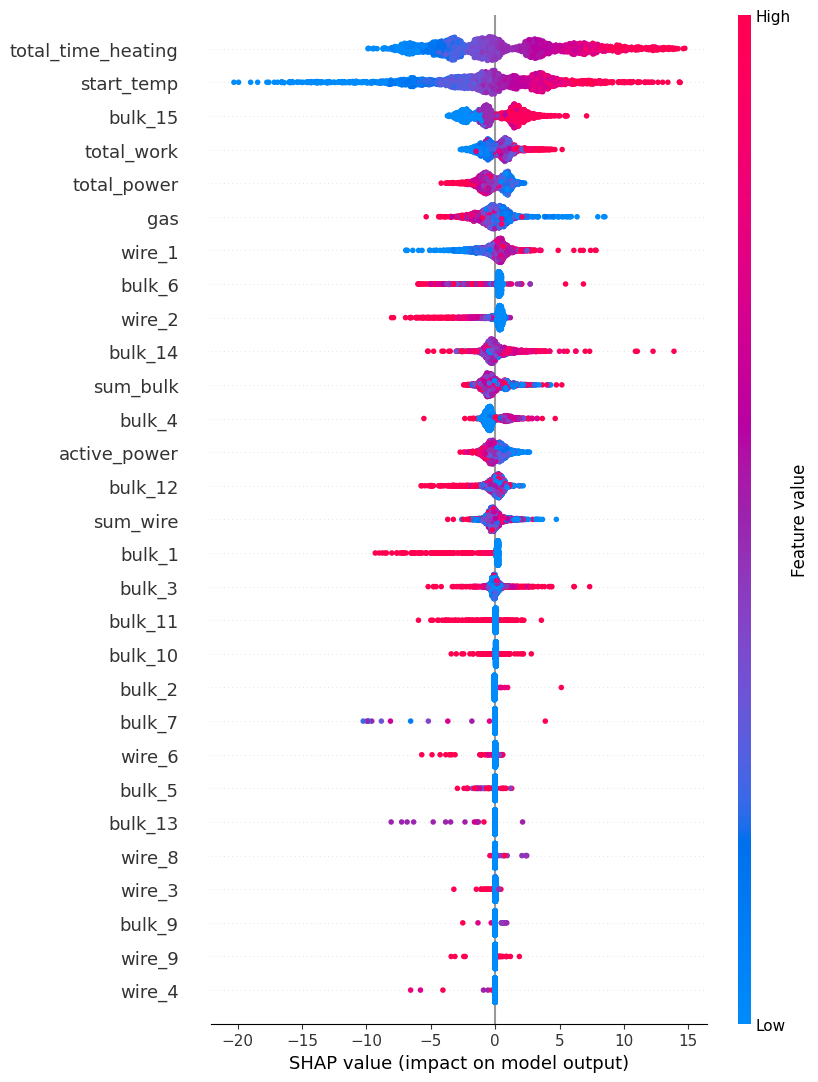

In [198]:
shap.plots.beeswarm(shap_values, max_display=30)

Судя по графику наибольшее влияние на модель оказывает начальная температура и общая длительность нагрева. Остальные параметры оказывают схожее влияние (с учетом количества данных)

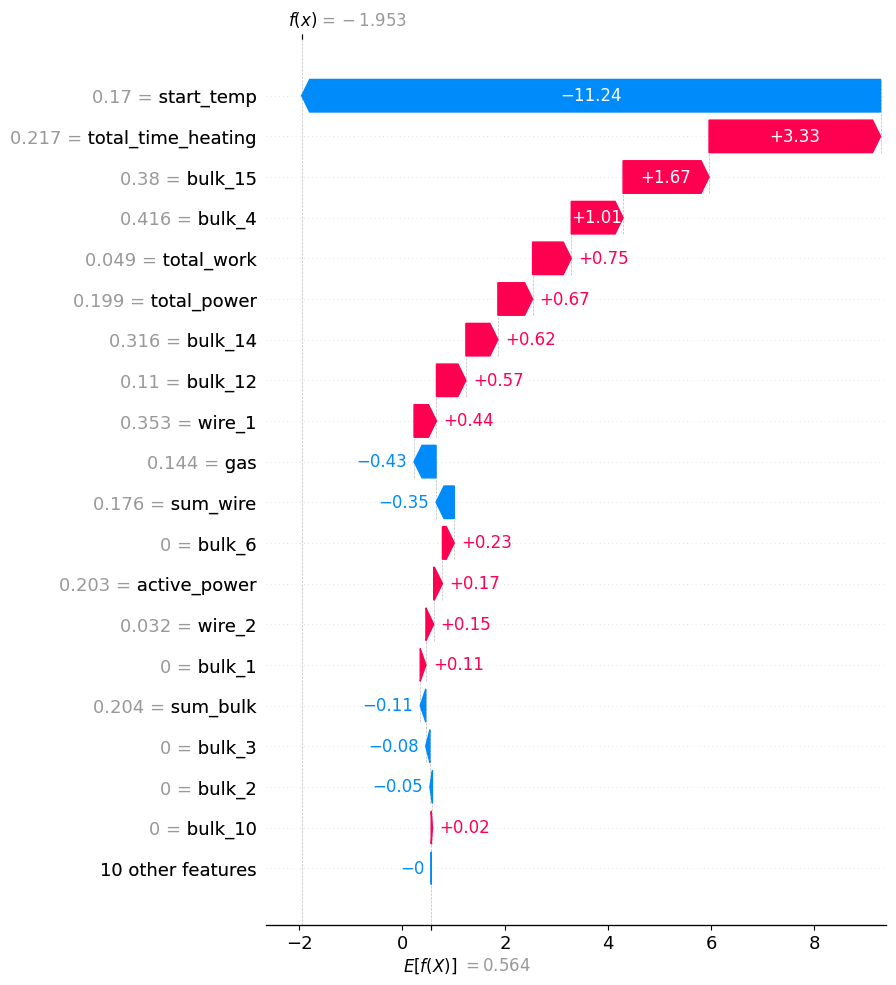

In [200]:
shap.plots.waterfall(shap_values[5], max_display=20) 

По данному графику можно сделать вывод, что модель соответствует реальному объекту. Начальная температура и затраты на нагрев (в том числе и время) оказывают наибольшее влияние. Также выделяются добавки 15, 4, 14, 12. Вероятно, это материалы с высокой теплопроводностью.

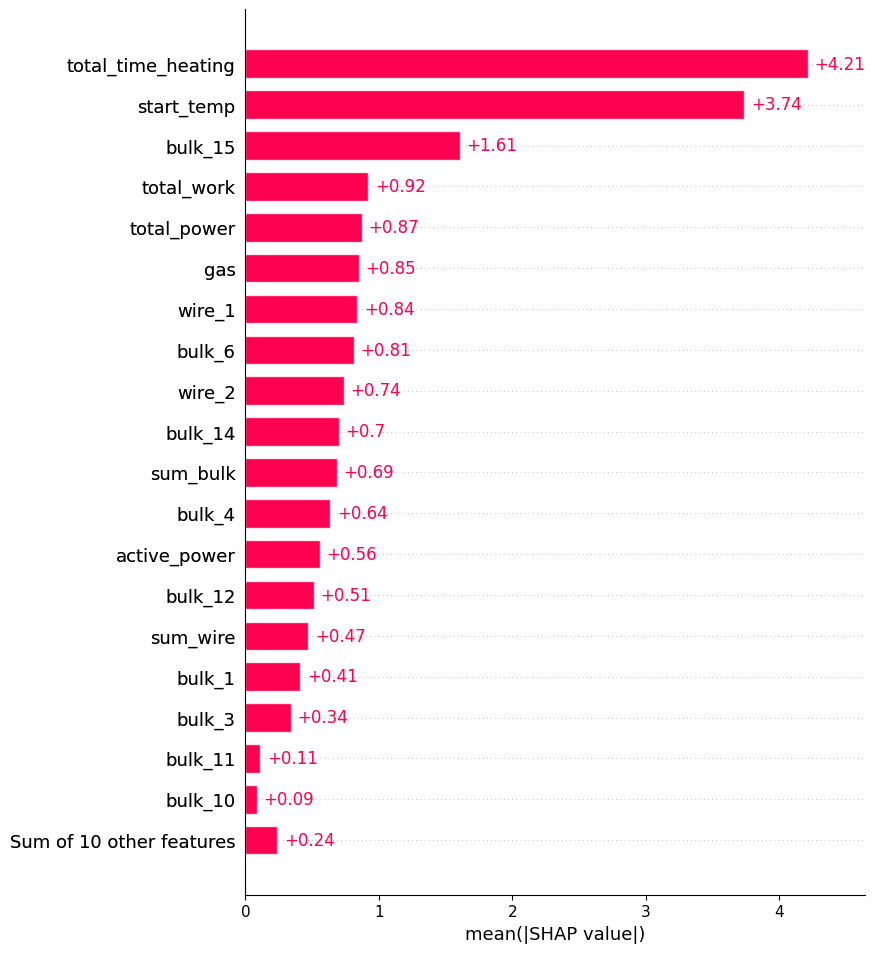

In [202]:
shap.plots.bar(shap_values, max_display=20) 

Вывод по графику "bar" аналогичен предыдущим.

### Вывод

In [205]:
print('Линейная регрессия:')
check_model(MAE_linear, percent_linear)
print('Решающее дерево:')
check_model(MAE_tree, percent_tree)
print('CatBoostRegressor:')
check_model(MAE_catboost, percent_catboost)

Линейная регрессия:
MAE (12.3) больше критерия (6.8) на 81.23 %, соответственно модель не подходит
Решающее дерево:
MAE (7.1) больше критерия (6.8) на 4.82 %, соответственно модель не подходит
CatBoostRegressor:
MAE (6.4) меньшее критерия на 5.99 %, можно сравнивать далее


- В качестве моделей для тестирования были рассмотрены: 1) Линейная регрессия; 2) Решающее дерево; 3) CatBoost;<br>
- Единственной подходящей моделью оказался CatBoostRegressor c "learning_rate" = 0.1;
- MAE лучше модели на ~6 % ниже критерия.

Влияние переменных на модель:<br>
- Начальная температура и затраты на нагрев (в том числе и время) оказывают наибольшее влияние.<br>
- Также выделяются добавки 15, 4, 14, 12. 

Далее проверим модель на тестовых данных

## Проверка на тестовых данных

In [210]:
best_cbr.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['total_time_heating',
                                                   'active_power',
                                                   'total_power', 'total_work',
                                                   'bulk_1', 'bulk_2', 'bulk_3',
                                                   'bulk_4', 'bulk_5', 'bulk_6',
                                                   'bulk_7', 'bulk_9',
                                                   'bulk_10', 'bulk_11',
                                                   'bulk_12', 'bulk_13',
                                                   'bulk_14', 'bulk_15',
                                                   'sum_bulk', 'gas',
                                                   'start_temp', 'wire_1',
                                                   'wire_2', 'wire_3', 'wire_4',
                                                   'wire_6', 'wire_8', 'wire_9',
                                                   'sum_wire'])])),
                ('models',
                 <catboost.core.CatBoostRegressor object at 0x0000028C9243F950>)])

In [211]:
test_ = best_cbr.predict(X_test)

In [212]:
MAE_cbr = mean_absolute_error(test_, y_test)

In [213]:
MAE_cbr, percent_linear = check_MAE(MAE_cbr, MAE=True)

Метрика MAE на тестовой выборке: 6.300213250052701
Отличие от MAE целевого: -7.35 %


Модель соответствует заявленным требованиям.

## Вывод

1) Проведена подготовка данных:<br>
    - В таблицах bulk_new, wire_new отстутствующие значения заменены на 0;<br>
    - Таблица с измерением температур агрегирована и преобразована в таблицу с исходными анными и конечными;<br>
    - Таблица arc_new агрегирована и добавлены производные от мощностей;<br>
    - По ключу отфильтрованы данные при следущих условиях: мощность не соответствует реальности, отсутствует конечная температура.<br>
2) Изучена корреляция признаков с помощью библиотеки phik;<br>
3) Обучены 3 модели регрессии:<br>
    - Линейная регрессия;<br>
    - Решающее дерево;<br>
    - CatBoostRegressor.<br>
4) Из обученных моделей подошла только CatBoostRegressor с MAE на тестовой выборке 6.3;<br>
5) Наибольшее влияние на модель оказывают:<br>
    - Начальная температура и затраты на нагрев (в том числе и время) оказывают наибольшее влияние;<br>
    - Также выделяются добавки 15, 4, 14, 12.